# SALUD MURCIA

In [1]:
from pandas import read_csv
import pandas as pd
from pandas.plotting import lag_plot
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import io

Lectura del conjunto de datos obtenido de la pagina de salud de Murcia 
https://www.murciasalud.es/pagina.php?id=458869
Recogidos desde el 08/03/2020 hasta el dia 25/03/2020

In [2]:
lectura = read_csv('../Datos_originales/casos_diarios_total_regional.csv', skiprows = 4, encoding='latin-1', sep = ';', na_values = ['NaN', 'NaT'])

# Headers = columnas de mi conjunto de datos. Si no especificamos asume que son las de la primera fila leida
# Skiprows = n: con n = numero de filas que quiero saltar. Las cuatro primeras son texto -> las saltamos
# Encoding = 'latin-1': para que no de errores de codificacion de algunos caracteres 
# Sep = ';': delimitador que separa las columnas
# Index_col = 0: usar la primera columna (fechas) como filas del dataframe

Renombramos los nombres de algunas de las columnas para que queden mas compactos

In [3]:
datos = lectura.rename(columns={'Pruebas_PCR_Ag':'Pruebas',
                                'Casos_incidentes_PCR/Ag+':'Incidentes',
                                'Hospitalizados': 'H',
                                'Hospitaliz_UCI':'H_UCI',
                                'Asintomatico_hombre_<45años': 'Asint_H_<45',
                                'Asintomatico_hombre_45a64años': 'Asint_H_45a64',
                                'Asintomatico_hombre_+65años': 'Asint_H_+65',
                                'Sintomatico_hombre_<45años': 'Sint_H_<45',
                                'Sintomatico_hombre_45a64años': 'Sint_H_45a64',
                                'Sintomatico_hombre_+65años': 'Sint_H_+65',
                                'Asintomatico_mujer_<45años': 'Asint_M_<45',
                                'Asintomatico_mujer_45a64años': 'Asint_M_45a64',
                                'Asintomatico_mujer_+65años': 'Asint_M_+65',
                                'Sintomatico_mujer_<45años': 'Sint_M_<45',
                                'Sintomatico_mujer_45a64años': 'Sint_M_45a64',
                                'Sintomatico_mujer_+65años': 'Sint_M_+65'})

Convertimos los datos leidos en un dataFrame y lo mostramos para ver su apariencia

In [4]:
df_salud_murcia = pd.DataFrame(datos)
df_salud_murcia.head(3)

,Fecha,Pruebas,Incidentes,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65
0,08/03/2020,130.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,09/03/2020,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2,10/03/2020,39.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0


Lo siguiente que haremos es indexar el dataframe por la columna 'Fecha'. Para ello, primero debemos convertir la misma en un objeto de tipo DatatimeIndex. Usamos la funcion 'to_datetime' y le indicamos el formato en el que se encuentran las fechas para que se lea y procese bien. Posteriormente eliminamos la columna del dataFrame e insertamos el nuevo DatatimeIndex como íncide del dataframe. Finalmente mostramos el resultado.

In [5]:
format = '%d/%m/%Y'
datetime_fecha = pd.to_datetime(df_salud_murcia['Fecha'], format = format)
df_salud_murcia = df_salud_murcia.drop(['Fecha'], axis=1)
df_salud_murcia.insert(0,'Fecha', datetime_fecha)
df_salud_murcia = df_salud_murcia.set_index('Fecha')
df_salud_murcia.head(3)

,Pruebas,Incidentes,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65
Fecha,,,,,,,,,,,,,,,,,
2020-03-08,130.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2020-03-09,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2020-03-10,39.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0


Con la siguiente función eliminamos todos aquellos valores que se almacenan o completan como NaN. 

In [6]:
df_salud_murcia.dropna(axis = 0, inplace = True)

## Sumando asintomáticos
En esta sección vamos a sumar a todos los asintomáticos (por fecha) y añadirlos en una nueva serie
del dataframe a la que llamaré "Asintomaticos"

In [7]:
df_salud_murcia['Asintomaticos'] = df_salud_murcia['Asint_H_<45'] + df_salud_murcia['Asint_H_45a64'] + df_salud_murcia['Asint_H_+65'] + df_salud_murcia['Asint_M_<45'] + df_salud_murcia['Asint_M_45a64'] + df_salud_murcia['Asint_M_+65']

A continuación lo que hacemos es guardarla en un archivo de extensión .csv 

In [8]:
df_salud_murcia.to_csv(path_or_buf = '../Datos_preprocesados./datos_suma_asintomaticos.csv')

## MOVILIDAD JUNTA

In [9]:
def parseador_fechas_marjun(nombre):
    # Cogemos el día
    dia = nombre[4:6]
    mes = nombre[6:9]
    anio = nombre[10:14]
    if mes == 'MAR':
        mes = '03'
    if mes == 'ABR':
        mes = '04'
    if mes == 'MAY':
        mes = '05'
    if mes == 'JUN':
        mes = '06'
    return(anio+'-'+dia+'-'+mes)

In [10]:
def parseador_fechas_jundic(nombre):
    # Cogemos la longitud total y nos quedamos con las fechas
    l = len(nombre)
    f = nombre[l-9:l-5]
    # Obtenemos el dia y el mes
    dia = f[0:2]
    mes = f[2:4]
    # El añi es siempre 2020
    anio = '2020'
    # Devolvemos la fecha en su formato
    return(anio+'-'+dia+'-'+mes)

Al igual que hicimos con el dataFrame de los datos de salud que leímos al principio, debemos transformar las fechas en objetos de tipo DatatimeIndex. Posteriormente las ordenaremos para que se muestren en orden cronológico. Para ello usamos la función 'to_datetime', que convierte nuestra lista de fechas en DatatimeIndex. Acto seguido creamos el dataframe con las entradas, las salidas a Murcia y las fechas y las ponemos como índice del dataframe. Ahora solo queda ordenarlo. Añadimos tres columnas adicionales al dataframe que son los meses, dias y años de las fechas. Ordenamos según estos valores y posteriormente las eliminamos del dataframe. Mostramos el resultado.

In [11]:
def conversor_a_dataframe(lista_fechas, lista_entradas, lista_salidas):
    format = '%Y-%d-%m'
    # Convertimos en DatatimeIndex
    fechas_serie = pd.to_datetime(lista_fechas, format = format)
    # Creamos dataframe con las entradas salidas y fechas
    df_entradas_salidas = pd.DataFrame(list(zip(lista_entradas, lista_salidas)), columns = ['Entradas', 'Salidas'], index = fechas_serie).rename_axis('Fecha', axis = 0)
    # Definimos las series para ordenar
    df_entradas_salidas['month'] = fechas_serie.month
    df_entradas_salidas['year'] = fechas_serie.year
    df_entradas_salidas['day'] = fechas_serie.day
    # Ordenamos por mes-dia-año
    df_entradas_salidas = df_entradas_salidas.sort_values(['month','day','year']).drop(columns=['day', 'month', 'year'])
    return df_entradas_salidas

### Movilidad mar-jun

In [12]:
ruta = '../Datos_originales/mar-jun/'

lista_entradas = []
lista_salidas = []
lista_fechas = []

# Cogemos los archivos .zip diarios
archivos = os.listdir(ruta)

# Iteramos sobre cada uno de estos
for a in archivos:
    # Los leemos con zipfile
    z = zipfile.ZipFile(ruta+a, 'r')
    # Iteramos en cada uno de los ficheros del zip
    for az in z.namelist():
        # Cogemos los .csv que nos interesan
        if "PobxCeldasOrigen" in az:
            # Nos quedamos con el dia (será el mismo para entrada y salida)
            fecha = parseador_fechas_marjun(az)
            lista_fechas.append(fecha)
            # Como son archivos .csv leemos
            df_f = pd.read_csv(z.open(az), sep=';', encoding = 'latin-1')
            # Obtenemos solamente las salidas de Murcia
            df_murcia = df_f[df_f['NOMBRE_CELDA_ORIGEN '].str.contains("Murcia \(")]
            # Sumamos toda la población registrada que sale de Murcia
            suma_salidas_murcia = df_murcia['POB_SALE '].sum()
            # Añadimos este dato a la lista de salidas
            lista_salidas.append(suma_salidas_murcia)
            
        if "PobxCeldasDestino" in az:
            # Como son archivos .csv leemos
            df_f = pd.read_csv(z.open(az), sep=';', encoding = 'latin-1')
            # Obtenemos solamente las entradas a Murcia
            df_murcia = df_f[df_f['NOMBRE_CELDA_DESTINO '].str.contains("Murcia \(")]
            # Sumamos toda la población registrada que llega a Murcia
            suma_entradas_murcia = df_murcia['POB_LLEGA '].sum()
            # Añadimos este dato a la lista de salidas
            lista_entradas.append(suma_entradas_murcia)

### Movilidad jun-dic

In [13]:
def procesamiento_tablas(nombre,z):
    # Obtenemos la fecha
    fecha = parseador_fechas_jundic(nombre)
    lista_fechas.append(fecha)
    # Leemos el fichero excel
    df = pd.read_excel(z.open(nombre))
    # Cogemos sólamente las áreas de Murcia ciudad
    df_murcia = df[df['Nombre del Área'].str.contains("Murcia \(")]
    # Entradas
    suma_entradas_murcia = df_murcia['Población residente encontrada durante el día en otra área (C)'].sum()
    lista_entradas.append(suma_entradas_murcia)
    # Salidas
    suma_salidas_murcia = df_murcia['Población no residente que se localiza durante el día en esta área (D)'].sum()
    lista_salidas.append(suma_salidas_murcia)

In [14]:
ruta = '../Datos_originales/jun-dic/'

# Cogemos los archivos .zip mensuales
archivos = os.listdir(ruta)

for a in archivos:
    with zipfile.ZipFile(ruta+a) as z:
        for f in z.namelist():
            # Todos excepto noviembre y diciembre tienen directamente las tablas
            if "Tabla 1.2" in f:
                procesamiento_tablas(f,z)
            # Extraemos los .zip diarios de noviembre y diciembre
            if ".zip" in f and ("Noviembre" in f or "Diciembre" in f):
                with z.open(f) as d:
                    with zipfile.ZipFile(d) as z2:
                        for h in z2.namelist():
                            if "Tabla 1.2" in h:
                                procesamiento_tablas(h,z2)
            

## DataFrame entradas y salidas Murcia

In [15]:
df_entradas_salidas_murcia = conversor_a_dataframe(lista_fechas, lista_entradas, lista_salidas)
df_entradas_salidas_murcia.to_csv(path_or_buf = '../Datos_preprocesados./datos_entradas_salidas_murcia.csv')

## DataFrame salud y entradas y salidas Murcia

In [16]:
df_final = pd.concat([df_salud_murcia, df_entradas_salidas_murcia], axis=1)
df_final.to_csv(path_or_buf = '../Datos_preprocesados./datos_murcia_mas_entradas_salidas.csv')

## Visualización de todas las series (bucle)

A continuación se realiza un bucle en el que se visualizan los datos de todas las series del dataframe

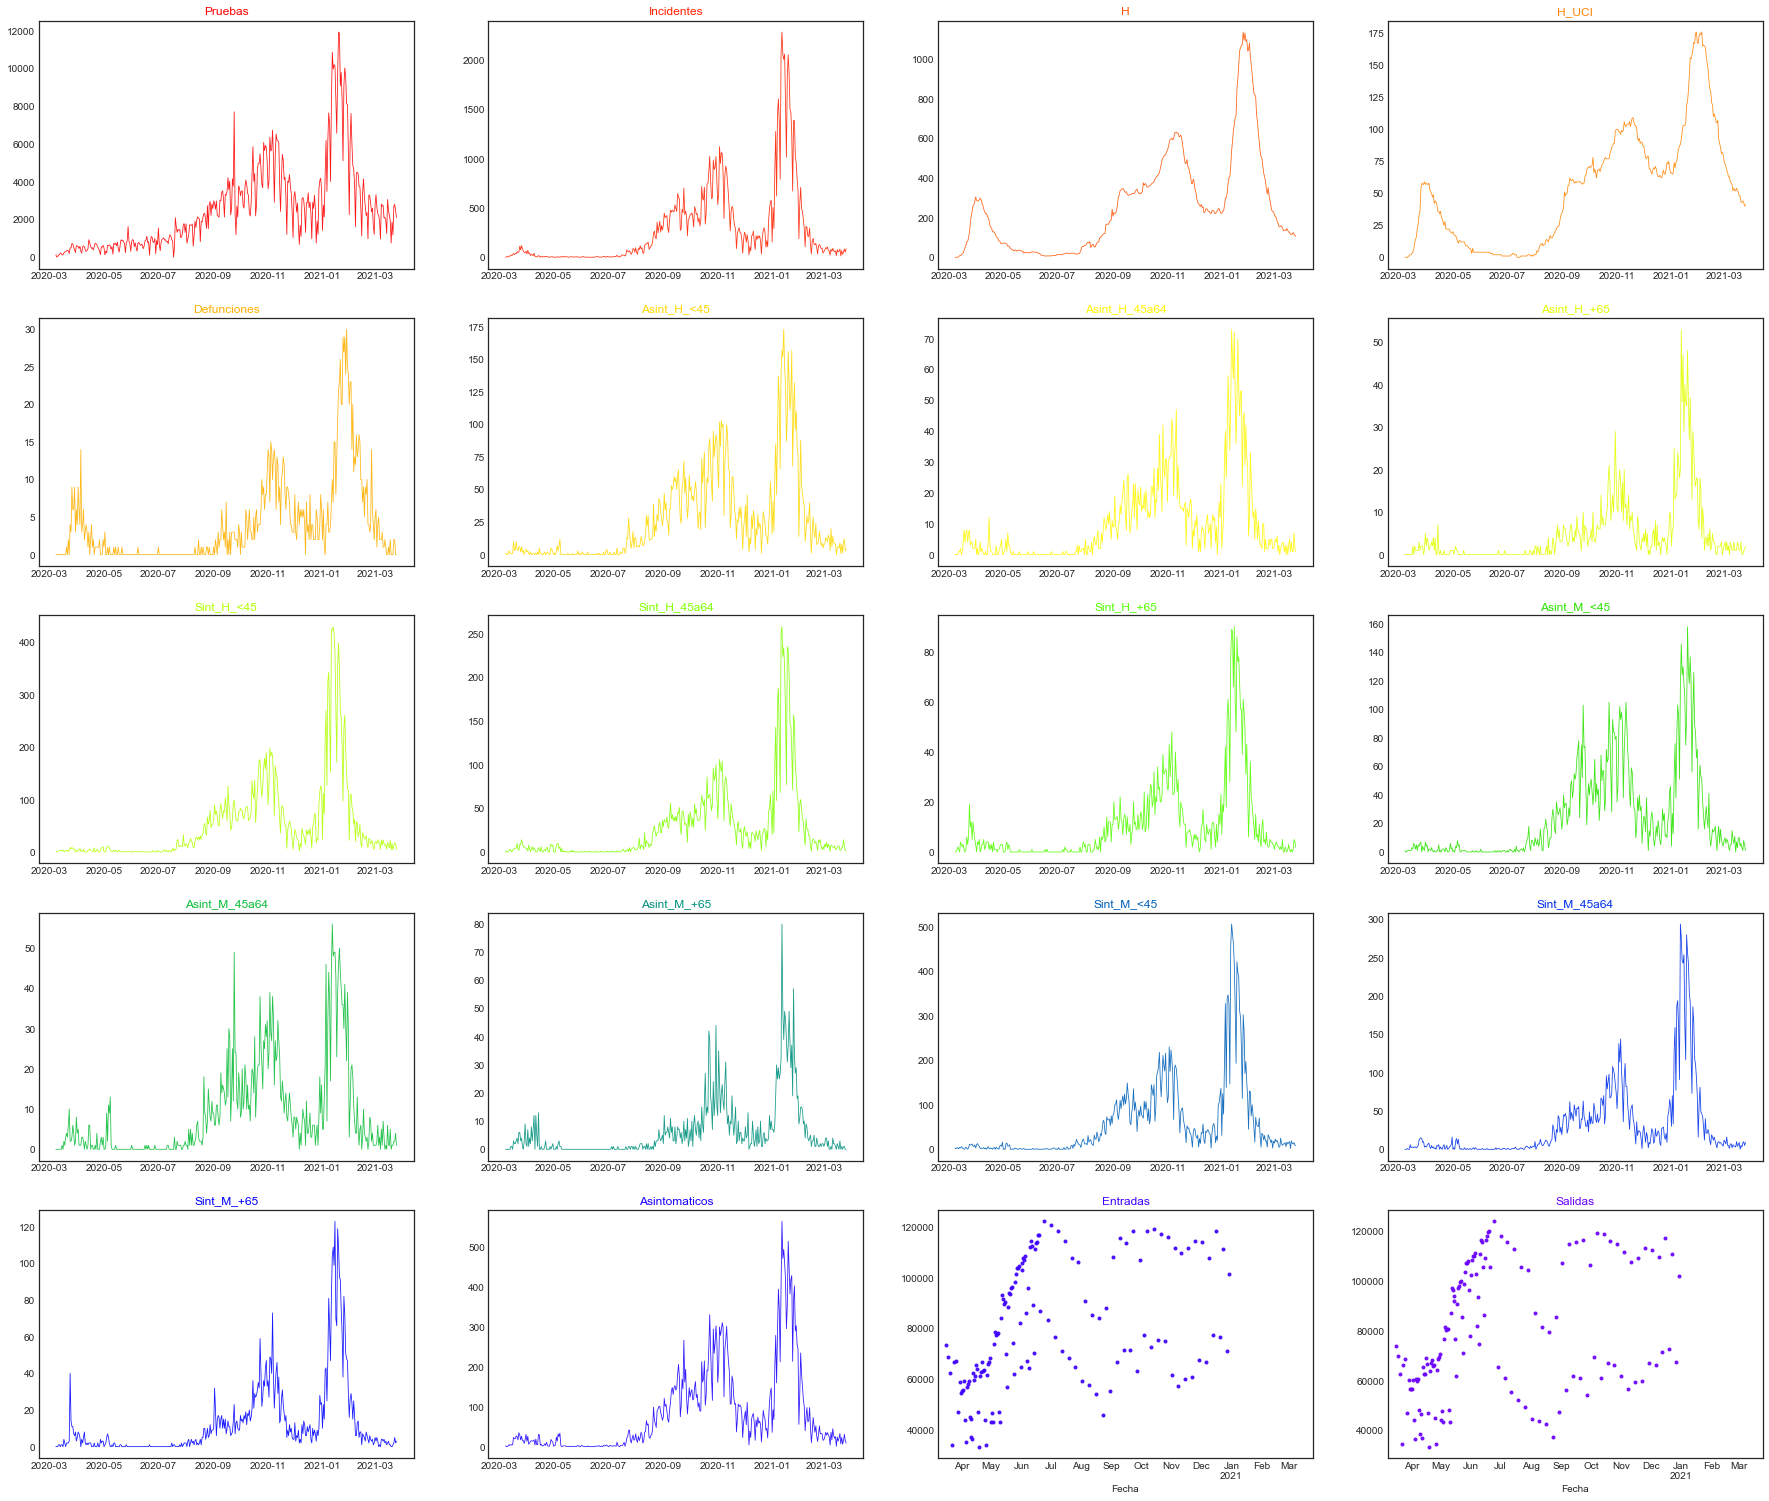

In [17]:
num = 0

# Initialize the figure style
plt.style.use('seaborn-white')
 
# create a color palette

palette = plt.get_cmap('prism')

for column in df_final:
    
    num = num + 1
 
    # Find the right spot on the plot
    plt.subplot(5,4, num)
 
    if "Salidas" in column or "Entradas" in column:
        serie = df_final[column]
        serie.plot(style = '.', color = palette(num), linewidth = 0.8, alpha = 0.9, label = column)
    else:
        # Plot the lineplot
        plt.plot(df_final[column], marker = '', color = palette(num), linewidth = 0.8, alpha = 0.9, label = column)

    # Add title
    plt.title(column, loc ='center', fontsize = 12, fontweight = 0, color = palette(num))

plt.subplots_adjust(left = 0.01, right = 4, top = 5, bottom = 0.01, hspace = 0.2, wspace = 0.2)


# Show the graph
plt.show()

Las gráficas tienen mucha similitud entre ellas, lo que es bastante lógico.
El aumento/disminución del número de casos positivos se ve directamente relacionado con 
el aumento de hospitalizaciones, defunciones, asintomáticos, sintomáticos,...